## Reto práctico transversal "Instala, entrena y experimenta con tu propia IA"

Bruno Contreras Moreira

En este cuaderno documento mi aprendizaje y trabajo con este reto.

### Fase 1: Análisis inicial, selección del modelo y configuración del entorno (Módulo 2)

+ ¿Qué reto has elegido y por qué?

Si en el informe del módulo 1 decía que:

"No lo tengo muy claro porque no sé todavía muy bien cómo aplicar LLMs a algo que no sea procesamiento de textos. 
Si fuera posible aprender cómo, me gustaría aplicarlo al análisis de secuencias de ADN por ejemplo, promotores de genes, para predecir en qué tejidos se expresarán."

Tras explorar algunos LLMs ahora lo refino a:

"Clasificar secuencias de ADN según contengan o no un motivo característico de un factor de transcripción, una tarea habitual en el estudio de la regulación de la expresión de genes en tejidos."

Un motivo se representa como consenso IUPAC, logo de secuencia o matriz de pesos, que en todos los datos son subsecuencias sobrerrepresentadas en las secuencias de interés, normalmente regiones promotoras de genes.

+ ¿Qué impacto esperas lograr con tu proyecto?

Espero averiguar hasta dónde puedo llegar preguntando a un LLM en vez de programando directamente las tareas necesarias. Compararé los resultados que obtenga con los obtenidos con un software especializado como [*peak-motifs*](https://pubmed.ncbi.nlm.nih.gov/22836136).

+ ¿Cómo vas a planificarte?

Dado que tengo a mi alcance una GPU NVIDIA 3090 en un sistema Ubuntu 20.04LTS me decidí por hacer el reto con un sistema local, no en la nube. Esta tarjeta gráfica tiene 24GB de RAM dedicada.

#### Instalación de llama.cpp

Cloné desde https://github.com/ggml-org/llama.cpp y descubrí que la versión de `cmake` de mi sistema sistema era insuficiente; la desinstalé y compilé desde código el fuente la versión 3.31.9. Tras resolver esto procedí a compilar `llama.cpp` para GPU como se explica en https://github.com/ggml-org/llama.cpp/blob/master/docs/build.md#cuda:

In [ ]:
cd $HOME
git clone https://github.com/ggml-org/llama.cpp.git
cd llama.cpp
cmake -B build -DGGML_CUDA=ON
cmake --build build --config Release
# media hora, pero una vez compilado podemos ejecutar el binario llama-cli
export LLAMACPPDIR=${HOME}/github/llama.cpp/build/
${LLAMACPPDIR}/bin/llama-cli

# si queremos que se descargue de un repositorio público un modelo específico haríamos
# bin/llama-cli -hf ggml-org/gemma-3-1b-it-GGUF
# los modelos se descargan en ${HOME}/.cache/llama.cpp/

Para elegir un modelo Llama adecuado hice varias pruebas.

Tras leer en material del curso que LLaMA 4 Scout permite identificar patrones en secuencias de ADN, lo instalé localmente con poca fe, dado que el fichero del modelo pesaba 37GB, mucho más que la RAM de mi GPU:

In [ ]:
${LLAMACPPDIR}/bin/llama-cli -hf unsloth/Llama-4-Scout-17B-16E-Instruct-GGUF
ls -lh  ~/.cache/llama.cpp/unsloth_Llama-4-Scout-17B-16E-Instruct-GGUF_Llama-4-Scout-17B-16E-Instruct-Q2_K.gguf
#37GB

#A pesar de mis limitaciones de hardware hice el siguiente intento:
${LLAMACPPDIR}/bin/llama-cli --model ${HOME}/.cache/llama.cpp/unsloth_Llama-4-Scout-17B-16E-Instruct-GGUa-4-Scout-17B-16E-Instruct-Q2_K.gguf --prompt "Parse the following DNA sequence and find all subsequences of length 6: ATCGATACTAGACTATACGACGACTACTGACGACT\n" --n-gpu-layers 25

Pude entonces observar que este modelo era demasiado lento en mi sistema y que, además, no hacía bien lo que le pedía, dado que cortaba subsecuencias de diferentes longitudes.

Probé entonces con modelos más pequeños. Primero descargué **bartowski_Meta-Llama-3.1-8B-Instruct-GGUF_Meta-Llama-3.1-8B-Instruct-Q4_K_M.gguf** y de nuevo observé que no hacía correctamente lo que le pedía. Sin embargo, animado por este 
[artículo](https://www.reddit.com/r/LocalLLaMA/comments/1caofxm/quick_speed_benchmark_for_llama_3_70b_on_1x_3090/?tl=es-es), 
probé con **bartowski_Meta-Llama-3.1-70B-Instruct-GGUF_Meta-Llama-3.1-70B-Instruct-Q4_K_M.gguf** tras repartir el modelo entre CPY y GPU con el parámetro `--n-gpu-layers`, como aprendí 
[aquí](https://www.reddit.com/r/LangChain/comments/18lb4n4/llamacpp_on_mac_n_gpu_layers_n_batch):

In [ ]:
${LLAMACPPDIR}/bin/llama-cli --model ~/.cache/llama.cpp/bartowski_Meta-Llama-3.1-70B-Instruct-GGUF_Meta-Llama-3.1-70B-Instruct-Q4_K_M.gguf --prompt "Parse the following DNA sequence and find all subsequences of length 6: ATCGATACTAGCTG\n" --n-gpu-layers 40
#después le pregunté "can you make a table of frequencies of subsequences?" y me gustó la respuesta en formato Markdown

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 3090, compute capability 8.6, VMM: yes
build: 6838 (226f295f4) with cc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0 for x86_64-linux-gnu
main: llama backend init
main: load the model and apply lora adapter, if any
llama_model_load_from_file_impl: using device CUDA0 (NVIDIA GeForce RTX 3090) (0000:af:00.0) - 23289 MiB free
llama_model_loader: loaded meta data with 33 key-value pairs and 724 tensors from /home/contrera/.cache/llama.cpp/bartowski_Meta-Llama-3.1-70B-Instruct-GGUF_Meta-Llama-3.1-70B-Instruct-Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_mode

Tras estas pruebas de momento elegiría el modelo **Llama-3.1-70B-Instruct**, pero igual me veo obligado a usar **Llama-3.1-8B-Instruct** porque corre mucho más rápido en mi sistema local. Otra opción sería usar un modelo como [llama-dna](https://huggingface.co/dnagpt/llama-dna/tree/main), como me recomendaron los profesores en el foro. 

Por reforzar mi elección, tras asistir a la [clase virtual](https://www.youtube.com/live/ocTqgMAMDpQ) le pregunté a [Claude](https://claude.ai/share/769a7e3e-c43a-4a14-936b-da3107112faf) y me confirmó que para mi tarjeta gráfica y mi área de interés el modelo **Llama 3.1 70B (cuantizado Q4_K_M)** sería la mejor opción entre los LLMs de uso general. Sin embargo, dada la naturaleza de mi problema me recomendó modelos CNN/transformers especializados como **DNABERT-2** (pre-entrenado en genomas, no tengo clara la licencia), **[Enformer](https://www.nature.com/articles/s41592-021-01252-x)** (para predecir expresión de genes, Apache license 2.0) y **[Nucleotide Transformer](https://pmc.ncbi.nlm.nih.gov/articles/PMC11810778)** (muy bueno para clasificación, también mi caso, Creative Commons Attribution Non Commercial Share Alike 4.0). Por lo que pude ver están disponibles en HuggingFace, así que podría probarlos y si fuera necesario convertirlos a formato GGUF podría seguir este [tutorial](https://www.geeksforgeeks.org/machine-learning/how-to-convert-any-huggingface-model-to-gguf-file-format).

Finalmente, tras leer el libro 3.1 y revisar el proceso de entrenamiento parece claro que necesitaré un entorno local con diferentes librerías python instaladas, no bastará con el binario *llama.cpp*. 

#### Creación de un entorno virtual

In [ ]:
cd $HOME

## 1er intento, pareció funcionar pero más tarde se quejaba de:
## Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`
#sudo apt install python3.8-venv, required in Ubuntu20.04
#python3 -m venv llmenv
#source ${HOME}/llmenv/bin/activate
#pip install torch transformers datasets
# compilamos llama-cpp-python con soporte CUDA
#CMAKE_ARGS="-DGGML_CUDA=on" pip install llama-cpp-python

## 2o intento, con entorno virtual conda (ocupa 7.9G)
#conda create -n "AIenv" python=3.11 ipython ipywidgets
conda activate AIenv
pip install torch transformers datasets sentencepiece scikit-learn matplotlib
# compilamos llama-cpp-python con soporte CUDA
CMAKE_ARGS="-DGGML_CUDA=on" pip install llama-cpp-python
# para evitar el error mencionado antes
pip install -U accelerate
pip list

Package                  Version
------------------------ -----------
aiohappyeyeballs         2.6.1
aiohttp                  3.13.2
aiosignal                1.4.0
anyio                    4.11.0
asttokens                3.0.0
attrs                    25.4.0
certifi                  2025.10.5
charset-normalizer       3.4.4
comm                     0.2.3
datasets                 4.4.1
debugpy                  1.8.17
decorator                5.2.1
dill                     0.4.0
diskcache                5.6.3
executing                2.2.1
filelock                 3.20.0
frozenlist               1.8.0
fsspec                   2025.10.0
h11                      0.16.0
hf-xet                   1.2.0
httpcore                 1.0.9
httpx                    0.28.1
huggingface-hub          0.36.0
idna                     3.11
importlib_metadata       8.7.0
ipykernel                7.1.0
ipython                  9.7.0
ipython_pygments_lexers  1.1.1
ipywidgets               8.1.8
jedi            

In [2]:
# compruebo que puedo usar librerías con ejemplo de 
# https://huggingface.co/dnagpt/llama-dna
from transformers import LlamaForCausalLM,LlamaTokenizer
from huggingface_hub import login
import os

mytoken = os.getenv('HFROTOKEN')
login(token=mytoken)

tokenizer = LlamaTokenizer.from_pretrained("dnagpt/llama-dna")
tokenizer.pad_token = tokenizer.eos_token
model = LlamaForCausalLM.from_pretrained("dnagpt/llama-dna")
# descarga en ${HOME}/.cache/huggingface/hub/models--dnagpt--llama-dna/

text='''GCTGACTCTGCCAGGATGGAATGAAATTAGGTTGTTTTAATTATAATGTAAAGTCAGTTCTAGTCAGACATAGTCACATAGGCAAGTAAGGGAACCTAAAATTGCTTGGAAT,
The primary use of LLaMA is research on large language models, including'''
print(f"Tokenized by DNA-LLaMA tokenizer:{tokenizer.tokenize(text)}")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Tokenized by DNA-LLaMA tokenizer:['▁GCTGA', 'CTCTG', 'CCAGGA', 'TGGAA', 'TGAAATTA', 'GGT', 'TG', 'TTTTA', 'AT', 'TATAATG', 'TAAAGTCA', 'GT', 'TCTAGTCA', 'GACATA', 'GTCACATA', 'GGCAA', 'GTAA', 'GGGAA', 'CCTAAA', 'AT', 'TG', 'CTTGGA', 'AT', ',', '<0x0A>', 'The', '▁primary', '▁use', '▁of', '▁L', 'La', 'MA', '▁is', '▁research', '▁on', '▁large', '▁language', '▁models', ',', '▁including']


Para completar el entorno local faltaría clonar el repositorio con el código y los datos y enlazarlo la nueva carpeta al directorio $HOME:

In [ ]:
git clone https://github.com/brunocontrerasmoreira/retoIAOpenSource.git
ln -s retoIAOpenSource ${HOME}/reto

### Fase 2.1: Desarrollo del proyecto, generación de prompts, ejecución y recogida de resultados (Módulo 3)

#### Dataset seleccionado y su preparación

<!-- Describe el conjunto de datos elegido, indicando su origen, características principales y cualquier preprocesamiento realizado (limpieza, balanceo, segmentación) -->
Para el reto voy a usar un *dataset* o conjunto de datos compuesto por secuencias de ADN del genoma de ratón (versión mm9) 
que en un experimento de [ChIPseq](https://es.wikipedia.org/wiki/CHIP-seq)
se descubrió eran dianas de la proteína o factor de transcripción **p300** en genes expresados en el corazón. 
Como conjunto negativo usaré datos ChIPseq de *p300* pero tomados en muestras de tejidos de extremidades por 
[Blow et al, 2010](https://pubmed.ncbi.nlm.nih.gov/20729851). Se corresponden con los ficheros *test* y *control* de la 
demo del algoritmo *peak-motifs* en <https://rsat.eead.csic.es/plants>.
Cada fichero tiene exactamente 1000 secuencias, así que este *dataset* está perfectamente balanceado.
De los ficheros originales he tomado las secuencias y sus identificadores, las he convertido a mayúsculas y he calculado para cada una de ellas la frecuencia de dinucleótidos canónicos por si ayudan al clasificador que quiero entrenar. La columna *ChIPseq* toma valores binarios, donde 1 significa que en el experimento *p300* se unió a esa secuencia.
Tras repasar la [documentación](https://huggingface.co/docs/trl/dataset_formats)
sobre *datasets*, los he convertido a formato CSV con las siguientes columnas:

id;sequence;ChIPseq;AA;AC;AG;AT;CA;CC;CG;GA;GC;TA

Estas operaciones las he hecho con ayuda del *script* [dataset.pl](../scripts/dataset.pl) en lenguaje Perl:

In [4]:
cd $HOME
perl ${HOME}/reto/scripts/dataset.pl ${HOME}/reto/data/peak-motifs_GSM559652_heart_p300_1000peaks.fa 1 > ${HOME}/reto/data/True.csv
perl ${HOME}/reto/scripts/dataset.pl ${HOME}/reto/data/peak-motifs_GSM348066_limb_p300_1000peaks.fa 0 > ${HOME}/reto/data/False.csv

# muestro las primeras líneas de cada archivo
head -n5 ${HOME}/reto/data/True.csv
head -n5 ${HOME}/reto/data/False.csv

# cuento el número de líneas de cada archivo
wc -l ${HOME}/reto/data/True.csv
wc -l ${HOME}/reto/data/False.csv


id;sequence;ChIPseq;AA;AC;AG;AT;CA;CC;CG;GA;GC;TA
mm9_chr10_110355828_110356672_+;TCTAGTGGACCTCAGGAGTAGCAGAAAAAGGACAATCGCTTGCTGAAAAAAAGGGAACATGAACTACCCTGCTTCCTTCAGTGAAAACAAACCAGAAGCCCCTCCCGTAAGAAGTGCAGCAAGCTGCGGAGGTAAAGCAAACAGATCGGAATCGTGAATGTAAGAATTGCTGGTATTTAGAAAAGCTCACAGCAGGCACCCATGCTTTCAAACTCCTGCCGCAATCTGGGGGAGATGTCAATCACTACTTGCACTGTTTTTCAACAGTCCTTGGTGGACAGAGAATCTGGCTGCAATTACGAGCTTATTTTGGATTGGGCCCAGCATACGACATAAAAAGGCATAAACCAGGCCTGTACTTTGTCACCGGAGGGGCCTTCCTCAACTCTGCCTCCTCCTACCCCCCCTAACAGGGCCTTTGGCAACGTAAGCGGGAAATTTTTTATTGTCGCAACGCGAGGGTACTGGCATCTATCAGTTAAAGTCATCCTAACCCCCACCAAAGAACTAGGCTATTAACAGCATGATGTTGCGCCTGGATGAAAGGGGTGATCGATTTGTGACAGAGGGGAGTAGTTTTGGTCGCTGCCTATTGCGGCGTGGAGGTCACCACTCTTCAAATACTAATTCTTAGGGCAACCCACTACTGATGACAGAGAAGTGGATCACCAAATGTCCTAGAATACAAACCAGATAGAGATGACATTATTTTGCTTTTTGTCTAGAACAATAATATGTCACCTCAAGCCCAGATTTTAGGTCCTTTCTGCTGTCTTCGCCGGCGAGACATCCCTGGACTTTTCGGACAACTGCAAACAATTGCAAACTGAAACCCGAAGCCTTT;1;0.176;0.103;0.142;0.055;0.141;0.129;0.028;0.119;0.059;0.047
mm9_chr10_1

##### Segmentación 

A continuación toca segmentar los datos en tres conjuntos (train, validation, test):
+ Conjunto de entrenamiento (train): se utiliza para ajustar los parámetros del modelo (60%)
+ Conjunto de validación (validation): se emplea para ajustar hiperparámetros y detectar sobreajuste (20%)
+ Conjunto de prueba (test): se usa únicamente para evaluar el rendimiento final (20%)

Lo haré con los siguientes comandos Perl en el terminal:

In [5]:
# la primera línea es el encabezado ($.==1)
perl -lne 'print if($.==1 || ($.>1&&$.<=601))' ${HOME}/reto/data/True.csv > ${HOME}/reto/data/train.csv
perl -lne 'print if($.>1&&$.<=601)' ${HOME}/reto/data/False.csv >> ${HOME}/reto/data/train.csv

perl -lne 'print if($.==1 || ($.>601&&$.<=801))' ${HOME}/reto/data/True.csv > ${HOME}/reto/data/validation.csv
perl -lne 'print if($.>601&&$.<=801)' ${HOME}/reto/data/False.csv >> ${HOME}/reto/data/validation.csv

perl -lne 'print if($.==1 || $.>801)' ${HOME}/reto/data/True.csv > ${HOME}/reto/data/test.csv
perl -lne 'print if($.>801)' ${HOME}/reto/data/False.csv >> ${HOME}/reto/data/test.csv

# compruebo el número de líneas de cada archivo resultante
wc -l ${HOME}/reto/data/train.csv
wc -l ${HOME}/reto/data/validation.csv
wc -l ${HOME}/reto/data/test.csv

# también muestras más pequeñas para pruebas rápidas
head -n 10 ${HOME}/reto/data/train.csv > ${HOME}/reto/data/train_small.csv
head -n 10 ${HOME}/reto/data/validation.csv > ${HOME}/reto/data/validation_small.csv
head -n 10 ${HOME}/reto/data/test.csv > ${HOME}/reto/data/test_small.csv

1201 /home/contrera/reto/data/train.csv
401 /home/contrera/reto/data/validation.csv
401 /home/contrera/reto/data/test.csv


#### Hiperparámetros utilizados y configuración del experimento

Para este primer experimento probaré con el modelo **nucleotide-transformer** que mencioné antes y tiene licencia 
Creative Commons Attribution Non Commercial Share Alike 4.0.
Tras observar que mi GPU se queda sin memoria al entrenar la versión **InstaDeepAI/nucleotide-transformer-2.5b-multi-species**,
lo hago con **InstaDeepAI/nucleotide-transformer-v2-500m-multi-species**, como de hecho comentaban en https://doi.org/10.1101/2025.06.25.661622.
Cabe recordar también que el modelo **dnagpt/llama-dna** consume toda la RAM de mi GPU.

Para estas pruebas probaré con valores de hiperparámetros similares a los que usaron los 
[autores](https://github.com/huggingface/notebooks/blob/main/examples/nucleotide_transformer_dna_sequence_modelling.ipynb) 
para predecir promotores, una tarea similar.

Para graficar el proceso de aprendizaje usaré la métrica [F1](https://es.wikipedia.org/wiki/Valor-F),
la media armónica de la precisión (especificidad) y de la exhaustividad (sensibilidad).

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species and are newly initialized: ['classifier.dense.bias', 

Step,Training Loss,Validation Loss,F1 Score
100,0.674800,0.645909,0.682819
200,0.544600,0.621887,0.639053
300,0.460600,0.655638,0.739220
400,0.202200,0.856130,0.743243
500,0.124400,1.153534,0.718987
600,0.034900,1.253595,0.725490
700,0.005000,1.446697,0.707921
800,0.002100,1.559069,0.709832
900,0.000700,1.572917,0.710784
1000,0.000600,1.581066,0.707617


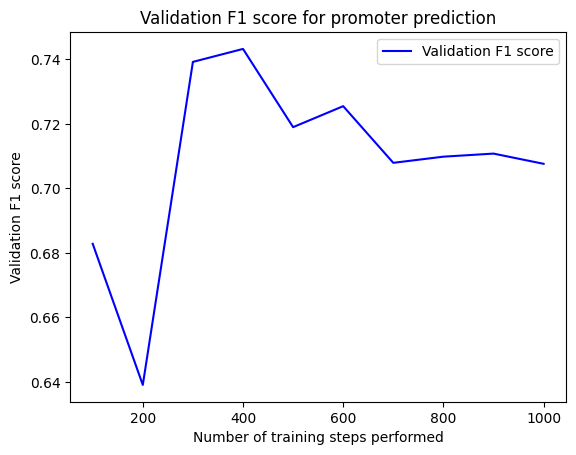

F1 en el subconjunto 'test': 0.7043701799485861


In [ ]:
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
from huggingface_hub import login
from datasets import load_dataset, Dataset
from sklearn.metrics import f1_score
import torch, os
import matplotlib.pyplot as plt
import numpy as np

# leo ficheros segmentados, me quedo solamente con columnas 'sequence' y 'ChIPseq', 
# que renombro como 'data' y 'labels' respectivamente
myhome = os.getenv('HOME')
dataset = {} 
for set in ['train','validation','test']:
   # filename = f"{myhome}/reto/data/{set}_small.csv"
    filename = f"{myhome}/reto/data/{set}.csv"
    ds_tmp = load_dataset('csv', delimiter=';', data_files=filename)
    dataset[set] = Dataset.from_dict({'data': ds_tmp['train']['sequence'],'labels': ds_tmp['train']['ChIPseq']})

# ChIPseq era originalmente True|False, causando este error:
# Error : Target size (torch.Size([8])) must be the same as input size (torch.Size([8, 2]))
# lo resolví convirtiéndolo a binario, me ayudó
# https://stackoverflow.com/questions/76216697/error-target-size-torch-size8-must-be-the-same-as-input-size-torch-size

# tokenizo las secuencias
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species")

def tokenize_function(examples):
    outputs = tokenizer(examples['data'])
    return outputs

tokenized_dataset = {}
for set in ['train','validation','test']:
  tokenized_dataset[set] = dataset[set].map(
    tokenize_function,
    batched=True,
    remove_columns=['data']
  )

# preparo para entrenamiento, para hiperparámetros me baso en
# https://github.com/huggingface/notebooks/blob/main/examples/nucleotide_transformer_dna_sequence_modelling.ipynb
batch_size = 8
myargs = TrainingArguments(
    'finetuned-NucleotideTransformer',
    remove_unused_columns=False,
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= 64,
    num_train_epochs= 2,
    logging_steps= 100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_score",
    label_names=['labels'],
    dataloader_drop_last=True,
    max_steps= 1000 
) 

# instanciamos el modelo que entrenaremos
model = AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species", 
  num_labels=2, trust_remote_code=True)

# usaremos la métrica F1 para evaluar el modelo que entrenemos;
def compute_metrics_f1_score(eval_pred):
    """Computes F1 score for binary classification"""
    predictions = np.argmax(eval_pred.predictions, axis=-1)
    references = eval_pred.label_ids
    r={'f1_score': f1_score(references, predictions)}
    return r

trainer = Trainer(
    model=model,
    args=myargs,
    train_dataset= tokenized_dataset['train'],
    eval_dataset= tokenized_dataset['validation'],
    processing_class=tokenizer,
    compute_metrics=compute_metrics_f1_score,
)

train_results = trainer.train()

# grafico de F1 en conjunto de validación durante el entrenamiento
curve_evaluation_f1_score =[[a['step'],a['eval_f1_score']] for a in trainer.state.log_history if 'eval_f1_score' in a.keys()]
eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
steps = [c[0] for c in curve_evaluation_f1_score]

plt.plot(steps, eval_f1_score, 'b', label='Validation F1 score')
plt.title('Validation F1 score for promoter prediction')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation F1 score')
plt.legend()
plt.show()

# finalmente calculo F1 en el conjunto 'test'
print(f"F1 en el subconjunto 'test': {trainer.predict(tokenized_dataset['test']).metrics['test_f1_score']}")


#### Resultados iniciales y su interpretación

En mi caso he trabajado con la métrica F1, que combina precisión y sensibilidad, obteniendo en el subconjunto de datos 'test' un valor de 0.70, ligeramente inferior al obtenido durante el proceso de entrenamiento. Este valor indica que estamos ante un modelo decente, mejor que un predictor aleatorio, pero tampoco excelente, pues se va a equivocar en 3 de cada 10 secuencias. Como no tenía experiencia previa la verdad no me parece un mal resultado. 
Los resultados que se obtienen al analizar las mismas secuencias con RSAT *peak-motifs* usando análisis de k-meros se pueden navegar en 
[data/peak-motifs-p300](../data/peak-motifs-p300).

#### Reflexión sobre posibles mejoras o ajustes

En mis pruebas he observado que aumentar el número de pasos o *steps* mejora el rendimiento, pero no llego a superar los valores de F1 obtenidos.
Se me ocurre que podría i) aumentar el tamaño del conjunto de datos, ii) hacer valicación cruzada a ver si obtengo una curva de F1 que converja o 
iii) ayudar al modelo usando no sólo las secuencias, por ejemplo añadiendo las frecuencias de nucleótidos precalculadas (pero no sé hacerlo con este modelo).

### Entrenamiento y validación avanzada del modelo

La lectura del libro 3.2 me da varias ideas para hacer una validación más avanzada del modelo.
Inicialmente me planteo hacer una validación cruzada dejando fuera el 20% de los datos (K=5), dado que mi dataset no es [demasiado grande](https://discuss.huggingface.co/t/do-transformers-need-cross-validation/4074). Sin embargo, tras consultarlo en el 
[foro](https://campus.aprende.csic.es/mod/forum/discuss.php?d=1132) y en 
[StackOverflow](https://stackoverflow.com/questions/75510487/huggingface-trainer-k-fold-cross-validation) 
decido finalmente seguir con la estrategia que ya tenía de validación *Hold-Out*.
Por tanto en esta sección intentaré modificar el código anterior para:
+ Calcular otras métricas aparte de F1, como **precisión**, **recall** y **exactitud**.
+ Evitar sobreentrenamiento por medio del mecanismo de decaimiento de pesos/*weight decay* (favorece pesos pequeños en la red neuronal) y parada temprana/*early stopping* (detiene el entrenamiento si la métrica objetivo empeora).

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species and are newly initialized: ['classifier.dense.bias', 

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.698900,0.690214,0.541667,0.653797,0.541667,0.413255
200,0.657400,0.662051,0.606771,0.607270,0.606771,0.606918


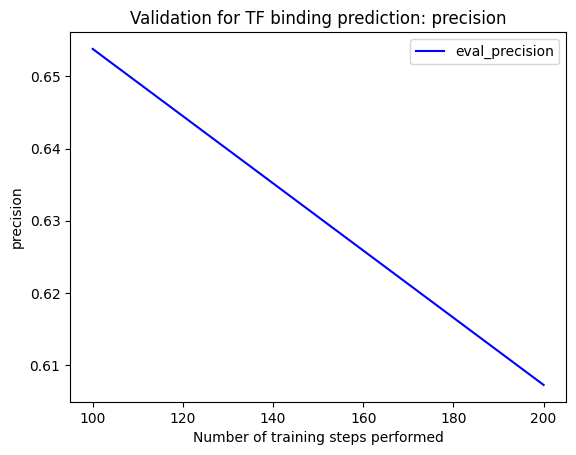

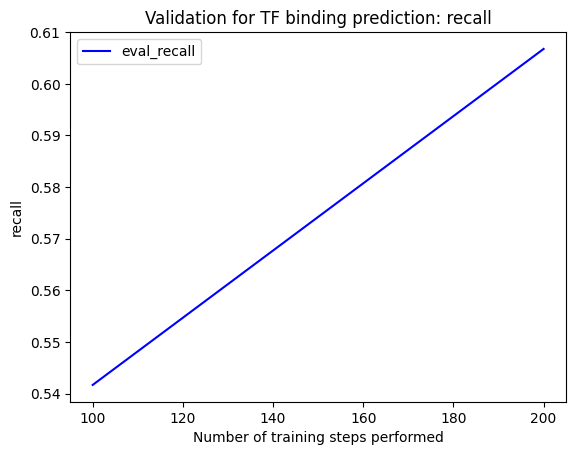

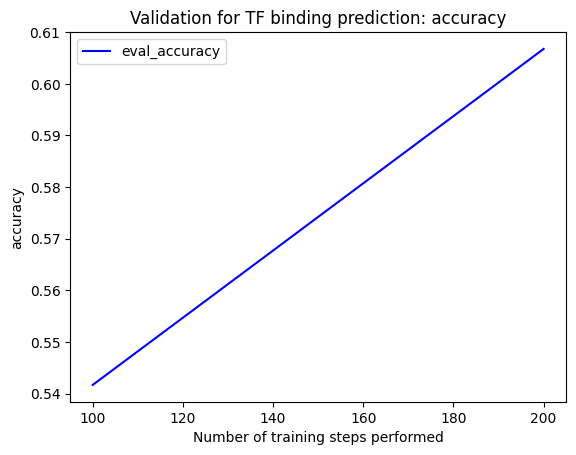

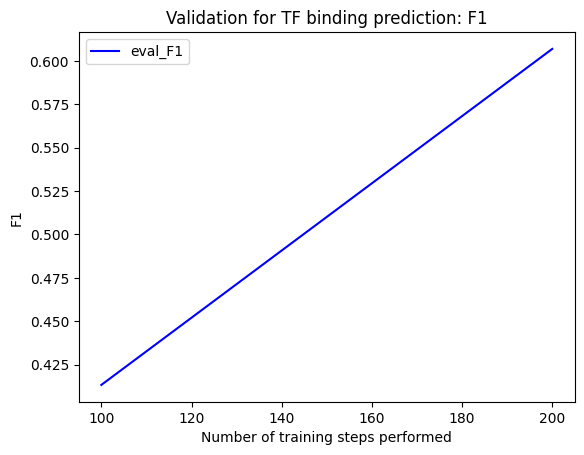

precision(test): 0.6268056913218203


recall(test): 0.625


accuracy(test): 0.625


F1(test): 0.6250712096139761


In [2]:
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification, EarlyStoppingCallback
from huggingface_hub import login
from datasets import load_dataset, Dataset
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
import torch, os
import matplotlib.pyplot as plt

# instancio el modelo de partida
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species")
model = AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species", 
  num_labels=2, trust_remote_code=True)

# nombro el modelo que vamos a entrenar
tuned_model_name='nucleotide-transformer-v2-500m-multi-species-p300'

myhome = os.getenv('HOME')
dataset = {} 
for set in ['train','validation','test']:
    filename = f"{myhome}/reto/data/{set}.csv"
    ds_tmp = load_dataset('csv', delimiter=';', data_files=filename)
    dataset[set] = Dataset.from_dict({'data': ds_tmp['train']['sequence'],'labels': ds_tmp['train']['ChIPseq']})

# tokenizo las secuencias
def tokenize_function(examples):
    outputs = tokenizer(examples['data'])
    return outputs

tokenized_dataset = {}
for set in ['train','validation','test']:
  tokenized_dataset[set] = dataset[set].map(
    tokenize_function,
    batched=True,
    remove_columns=['data']
  )

# preparo entrenamiento
batch_size = 8
myargs = TrainingArguments(
    tuned_model_name,
    remove_unused_columns=False,
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= 64,
    num_train_epochs= 2,
    logging_steps= 100,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    label_names=['labels'],
    dataloader_drop_last=True,
    max_steps= 200
) 

# https://medium.com/@rakeshrajpurohit/customized-evaluation-metrics-with-hugging-face-trainer-3ff00d936f99
def compute_all_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    F1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': F1
    }

trainer = Trainer(
    model=model,
    args=myargs,
    train_dataset= tokenized_dataset['train'],
    eval_dataset= tokenized_dataset['validation'],
    processing_class=tokenizer,
    compute_metrics=compute_all_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

train_results = trainer.train()

# gráficas de diferentes métricas en conjunto de validación durante el entrenamiento
for metric in ['precision','recall','accuracy','F1']:
  key = 'eval_' + metric
  curve_evaluation =[[a['step'],a[key]] for a in trainer.state.log_history if key in a.keys()]
  eval_metric = [c[1] for c in curve_evaluation]
  steps = [c[0] for c in curve_evaluation]

  plt.plot(steps, eval_metric, 'b', label=key)
  plt.title('Validation for TF binding prediction: ' + metric)
  plt.xlabel('Number of training steps performed')
  plt.ylabel(metric)
  plt.legend()
  plt.show()

# finalmente calculo métricas en el subconjunto 'test'
print(f"precision(test): {trainer.predict(tokenized_dataset['test']).metrics['test_precision']}")
print(f"recall(test): {trainer.predict(tokenized_dataset['test']).metrics['test_recall']}")
print(f"accuracy(test): {trainer.predict(tokenized_dataset['test']).metrics['test_accuracy']}")
print(f"F1(test): {trainer.predict(tokenized_dataset['test']).metrics['test_F1']}")

# guardo el modelo entrenado para su despliegue posterior
trainer.save_model(f"{myhome}/reto/models/{tuned_model_name}")
trainer.save_state()



### Fase 2.2: Despliegue controlado y aplicación científica (Módulo 4)

Llegados a este punto toca hacer un despliegue controlado del modelo ajustado en la sección anterior y aplicarlo a un caso práctico científico.    

#### Descripción del entorno elegido y su configuración

Mi idea inicial fue seguir la línea de secciones anteriores y desplegar localmente utilizando *llama.cpp*.
Sin embargo, tras seguir las instrucciones de 
[@thomasjvarghese49](https://medium.com/@thomasjvarghese49/run-your-own-fine-tuned-large-language-model-locally-without-any-internet-using-llama-cpp-part-1-a5db72801ccc) 
he descubierto que en mi caso no es posible porque la arquitectura de mi modelo (EsmForSequenceClassification)
no está soportada por *$HOME/llama.cpp/convert_hf_to_gguf.py*. 
Nota: en mis pruebas tampoco logré convertir el modelo **zhihan1996/DNABERT-2-117M**.

Por tanto, seguiré usando un entorno local pero con la infraestructura de la clase transformers de Hugging Face, 
la misma que usé para *fine tunning*. Para no desperdiciar recursos con un modelo muy preliminar no voy a subir
el modelo entreando al *Hugging Face Hub*; se guardará tras el entrenamiento en la carpeta models/ para las 
pruebas de despliegue. De la misma manera, por evitar problemas con la licencia no voy a subir al repositorio GitHub 
el modelo final ajustado por mi.

#### Prompt utilizado y justificación del diseño

Dada la naturaleza de mi reto, mi caso práctico consiste en la clasificación de secuencias de ADN no utilizadas durante el entrenamiento.
Para ello voy a obtener el conjunto completo de secuencias genómicas a las que se pega la proteína **p300** en muestras de corazón
del artículo original de [Blow et al, 2010](https://pubmed.ncbi.nlm.nih.gov/20729851). En concreto usaré los rangos genómicos de la
tabla [S4](https://static-content.springer.com/esm/art%3A10.1038%2Fng.650/MediaObjects/41588_2010_BFng650_MOESM20_ESM.xls), 
que convertiré a un fichero [BED](https://es.wikipedia.org/wiki/Formato_BED) para luego cortar esas secuencias del genoma de ratón
versión [mm9](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001635.18). 
Obviamente debo eliminar las secuencias incluídas que se hayan podido usar en el entrenamiento.
Todas estas operaciones las haré con las siguientes instrucciones en la línea de comando:

In [ ]:
cd ${HOME}/reto/data

# obtén todas los rangos genómicos de corazón del artículo en formato BED
perl -lane '$F[0]=~s/chr//;printf("%s\t%d\t%d\n",$F[0],$F[1]-1,$F[2])' SupplTable4Heartp300Peaks.txt | sort -k1,1 -k2,2n> SupplTable4Heartp300Peaks.bed

# haz un fichero BED con los rangos que se usaron en el entrenamiento
perl -lne 'if(/mm9_chr([^_]+)_(\d+)_(\d+)_/){ printf("%s\t%d\t%d\n",$1,$2-1,$3)}' peak-motifs_GSM559652_heart_p300_1000peaks.fa | sort -k1,1 -k2,2n > trainingPeaks.bed

# define los rangos para el caso de uso práctico
grep -Fo -f SupplTable4Heartp300Peaks.bed trainingPeaks.bed | grep -vFf - SupplTable4Heartp300Peaks.bed > usecase.bed

# descarga la secuencia FASTA del genoma mm9 y extraigo las 2597 secuencias que usaremos
wget http://ftp.ensembl.org/pub/release-54/fasta/mus_musculus/dna/Mus_musculus.NCBIM37.54.dna_rm.toplevel.fa.gz
gunzip Mus_musculus.NCBIM37.54.dna_rm.toplevel.fa.gz
bedtools getfasta -fi ~/Mus_musculus.NCBIM37.54.dna_rm.toplevel.fa -bed usecase.bed > usecase.fasta

En cuanto al prompt...

 	
ii) ¿Tiene sentido interrogar este modelo con un prompt si no lo entrenaste de esa manera?
Sí, tiene total sentido. La interacción con los modelos de lenguaje grandes (LLMs), incluso aquellos que han sido ajustados para tareas específicas, se realiza fundamentalmente a través de prompts.
Aunque entrenaste el modelo con un dataset etiquetado (fine-tuning), el objetivo de ese proceso fue especializar al modelo en un dominio o tarea concreta (como clasificación, análisis de sentimiento, o extracción de información). El modelo sigue siendo un Large Language Model (LLM) que utiliza la arquitectura transformer para procesar, comprender y generar lenguaje natural.
El prompt actúa como la instrucción o entrada que guía al modelo sobre lo que debe hacer. Por ejemplo:
1. Si fine-tuneaste para Clasificación: No le preguntarías, "¿Qué opinas de esto?". Le darías un prompt instruccional para que realice la tarea especializada, como:
2. Si fine-tuneaste para Resumen: Le darías un prompt de contexto que incluya el texto completo y la instrucción de resumen:
La importancia del diseño del prompt en modelos ajustados
El éxito de tu modelo ajustado en el entorno real, incluso en el despliegue con llama.cpp, dependerá de la calidad de tus prompts.
Deberás aplicar los principios de diseño de prompts efectivos para obtener resultados precisos y relevantes:
• Claridad: El prompt debe ser comprensible y sin ambigüedades.
• Especificidad: Debes detallar el formato, contenido y limitaciones de la respuesta esperada.
• Contexto: Incorporar información adicional o ejemplos (few-shot prompting) ayuda al modelo a generar respuestas más consistentes.

En resumen, el modelo ajustado necesita el prompt como dirección de trabajo. Aunque el fine-tuning le dio la capacidad de realizar la tarea con tu dataset etiquetado, el prompt le da la orden específica para aplicar esa capacidad en una nueva entrada de texto. Es un proceso iterativo donde la calidad del prompt mejora sustancialmente el resultado del modelo.


#### Resultados obtenidos, incluyendo ejemplos generados por el modelo

Ahora trataré de cargar el modelo entrenado e interrogarle con las secuencias que he preparado:

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from huggingface_hub import login
import os

#mytoken = os.getenv('HFROTOKEN')
#login(token=mytoken)

myhome = os.getenv('HOME')
#dataset = {}
#for set in ['train','validation','test']:
#   # filename = f"{myhome}/reto/data/{set}_small.csv"
#    filename = f"{myhome}/reto/data/{set}.csv"
#    ds_tmp = load_dataset('csv', delimiter=';', data_files=filename)
#    dataset[set] = Dataset.from_dict({'data': ds_tmp['train']['sequence'],'labels': ds_tmp['train']['ChIPseq']})


# tokenizo las secuencias
#tuned_model_name = 'brunocontreras/nucleotide-transformer-v2-500m-multi-species-p300'
tuned_model_name = 'nucleotide-transformer-v2-500m-multi-species-p300'
tuned_model_path = f'{myhome}/reto/models/{tuned_model_name}'
tokenizer = AutoTokenizer.from_pretrained(tuned_model_path,local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(tuned_model_path,local_files_only=True)







RuntimeError: Error(s) in loading state_dict for Linear:
	size mismatch for weight: copying a param with shape torch.Size([8192, 1024]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).

#### Resultados obtenidos, incluyendo ejemplos generados por el modelo


#### Análisis crítico: dificultades encontradas, lecciones aprendidas y propuestas de mejora.

El proceso de despliegue y los retos encontrados: me quedo sin RAM a veces y tengo que relanzar...

Buenas prácticas aplicadas y consejos para futuros despliegues.
Aplicabilidad del modelo en tu contexto profesional o científico.

### Fase 3: Redacción del informe final y documentación completa (Módulo 5)



### Fase 4: Entrega final y participación en actividades de cierre (Módulo 5)